## 1. Introduction/Business Problem


Travelers nowadays are constantly trying to find destinations that offer high quality food and drink for a fair price. Businesses also have to keep track of their neighborhood in order to understand their competitors and make strategic location decisions.

In this project, I'll try to check if its possible to cluster the neighborhoods in Boston, MA by taking into account the quality and cost of the venues located per neighborhood. The main objective of this analysis is to **determine the areas in the selected destinations that would be a good option for visitors looking for _cheap, high quality eating and drinking_.** A secondary objective is to offer an overview of the competition to the business owners in their same neighborhood.


## 2. Data

For this project, I'll use the Foursquare API and a dataset with all US zipcodes downloaded from the [simplemaps website](https://simplemaps.com/data/us-zips).

I'll split the selected destination based on the zip codes provided in the zip code dataset and I'll obtain the data related to the trending venues per neighborhood, the rating obtained by each venue and the "price" category it belongs to from the Foursquare API.

### 2.1 Foursquare API

The Foursquare API is a good source for information on popular venues per location. 

In [198]:
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

To get the venues around an specific area, we use the "search" end point and provide the latitude and longitude of the specific location. Let's say we decide to get the venues around an specific zipcode, this is how it would work:

In [ ]:
CLIENT_ID='AEO45ABRSDOJNO0RZOSZHLORAT5U52BBC1FNH0OEVZSX5UXP'
CLIENT_SECRET='VDWRYWJIWT3UH4JOA0SACQXRP322BBQUQWKL5TDZXHSBE5VP'
latitude=42.3577
longitude=-71.0651
VERSION='20180604'
radius=200
LIMIT='5'

In [ ]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
results

In [ ]:
#get relevant information from JSON
info=results['response']['groups'][0]['items']
info[0]

In [ ]:
df = json_normalize(info)
df_filtered=df[['venue.name','venue.id','venue.location.postalCode']]
df_filtered.rename(columns={'venue.name':'name','venue.id':'id','venue.location.postalCode':'postalCode'},inplace=True)

Turn info into a dataframe (using the code from one of the labs in the course)

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
df = json_normalize(info) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in df.columns if col.startswith('venue.location.')] + ['venue.id']
df_filtered = df.loc[:, filtered_columns]

# filter the category for each row
df_filtered['venue.categories'] = df_filtered.apply(get_category_type, axis=1)

# clean columns
df_filtered.columns = [col.split('.')[-1] for col in df_filtered.columns]

df_filtered.head()

I can get the venues ratings using the venues ids and getting it from the API

In [ ]:
venues_ids=df_filtered['id']
venues_ids

In [ ]:
df_filtered['rating']=0

In [ ]:
venue_id='4a549cd9f964a5202ab31fe3'
url='https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
result = requests.get(url).json()
result

In [ ]:
for venue_id, i in zip(venues_ids,range(0,len(venues_ids))):
    url='https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    df_filtered['rating'].loc[i]=result['response']['venue']['rating']
    try:
        print(result['response']['venue']['rating'])
    except:
        print('This venue has not been rated yet.')

In [ ]:
df_filtered

After that, we only need to repeat this for all neighborhoods and apply the clustering to find if it is possible to say which neighborhoods are a "cheap-high quality" option for the visitors.

### 2.2 US zip codes dataset

Here is how the US zip code dataset looks like.


In order to use the dataset, I downloaded it as a csv file into my computer from [this link](https://simplemaps.com/data/us-zips).

In [ ]:
path='/Users/nicolecapriles/Documents/uszips.csv'
zipcodes=pd.read_csv(path) 

The dataset contains the zip codes for all states in the US, their longitude and latitude and some other information. Check the headers below

In [ ]:
zipcodes.head()

I'll only need the zip code, latitude, longitude city and state. So we can drop all other columns in the dataframe.

In [ ]:
columns_drop=['zcta','parent_zcta','population','density','county_fips','county_name','all_county_weights','imprecise','military','timezone']
zipcodes.drop(columns_drop,axis=1,inplace=True)

In [ ]:
zipcodes.head()

Since I'll run the project with an specific destination (Boston), we can split this dataset to obtain the zipcodes per city.

In [199]:
Boston_zipcodes=zipcodes[(zipcodes['state_id']=='MA')&(zipcodes['city']=='Boston')]

These dataset contains the group of zipcodes I'll use to obtain the venues from the Foursquare API.

## 3. Methodology

These are the steps required to complete the project:
1. Obtain the data from the US zipcodes dataset.
2. Get the venues' names for the selected zip codes.
3. Arrange the data to fit it into the kmeans model.
4. Use kmeans clustering to cluster the neighborhoods based on the rating and prices of the venues.
5. Analyze the clustering results.

## 4. Results
### Boston, MA

First, let's check how many zipcodes we have available for the city by checking the shape of the dataframe.

In [200]:
#Check how many zip codes we have for Boston by getting the dataframe's shape
Boston_zipcodes.shape

(14, 6)

### (a) Get venues per zipcode

Let's define a function that allows us to get the venues for an specific latitude and logitude easily.

In [ ]:
def get_venue_info(CLIENT_ID,CLIENT_SECRET,latitude,longitude,VERSION,radius,LIMIT):
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    
    response=requests.get(url)
    results=response.json()
    
    if response.status_code==200:
        info=results['response']['groups'][0]['items']
       
        df=json_normalize(info)
        
        try:
            df_filtered=df[['venue.name','venue.id','venue.location.postalCode']]
            df_filtered.rename(columns={'venue.name':'name','venue.id':'id','venue.location.postalCode':'postalCode'},inplace=True)
        
            return df_filtered
    
        except:
            return None
        
    elif response.status_code!=200:
        
        return None

I'll create an empty dictionary that will hold all the dataframes generated per zipcode. The keys of this dictionary will by the zipcodes for a city.

In [ ]:
d = {zipcode: pd.DataFrame() for zipcode in Boston_zipcodes['zip']}

Now that all is set up, we can go ahead and run a loop to fill the created dictionary with the information desired about the searched venues in the Foursquare API. 

In [ ]:
CLIENT_ID='AEO45ABRSDOJNO0RZOSZHLORAT5U52BBC1FNH0OEVZSX5UXP' 
CLIENT_SECRET='VDWRYWJIWT3UH4JOA0SACQXRP322BBQUQWKL5TDZXHSBE5VP'
VERSION='20180604'
radius=200 #search radius around specified location
LIMIT='10' #number of venues you'd like to see per location. I chose 10 venues per zipcode.

for zipcode in Boston_zipcodes['zip']:
    #First get the latitude and longitude for the specific zipcode from the zipcodes data.
    latitude=float(Boston_zipcodes['lat'][Boston_zipcodes['zip']==zipcode])
    longitude=float(Boston_zipcodes['lng'][Boston_zipcodes['zip']==zipcode])
    
    #run the defined function for that location and save it into the dictionary.
    d[zipcode]=get_venue_info(CLIENT_ID,CLIENT_SECRET,latitude,longitude,VERSION,radius,LIMIT)

In [ ]:
#Create an empty dataframe to put all information together
df=pd.DataFrame()
keys=list(d.keys())

In [ ]:
#loop through each key in the dictionary to make one dataframe with the selected venues information per zipcode.
for i in range(len(keys)):
    df=df.append(d[keys[i]])
    
df.reset_index(drop=True,inplace=True)

Now we have a dataframe that contains the ten top venues per zipcode with the venue names and ids.

In [ ]:
df.head()

### (b) Get venue details

Now that we have the venue information, we can get the details on each venue using the venue id. Let's create a function that allows us to easily get them by providing the venue_id we got in the previous step.

In [ ]:
def get_venue_details(venue_id,CLIENT_ID, CLIENT_SECRET, VERSION):
    url='https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    response=requests.get(url)
    results=response.json()
    
    if response.status_code==200:
        try:
            rating=results['response']['venue']['rating']
        except:
            rating=0
            
        try:
            price=results['response']['venue']['price']['tier']
        except:
            price=0
        
        venue_details=pd.DataFrame([[venue_id,rating, price]],columns=['id','rating','price'])
        
        return venue_details
    
    elif response.status_code!=200:
        venue_details_error=pd.DataFrame([[venue_id,0,0]],columns=['id','rating','price'])
        
        return venue_details_error

In [ ]:
venues_ids=df['id']
v = {venue: pd.DataFrame() for venue in venues_ids}

In [ ]:
for venue_id in venues_ids:
    v[venue_id]=get_venue_details(venue_id,CLIENT_ID, CLIENT_SECRET, VERSION)

In [ ]:
#Create an empty dataframe to put all information together
df_details=pd.DataFrame()
keys_details=list(v.keys())

In [ ]:
for i in range(len(keys_details)):
    df_details=df_details.append(v[keys_details[i]])
    
df_details.reset_index(drop=True,inplace=True)

### (c) Put both dataframes together.

Now we join the dataframes resulted from the first step (venues names per zipcode) and the second step (venues details) using the _merge_ method.

In [202]:
final_df=pd.merge(df_details,df,on='id')

Since the calls to get the venue details are limited, I'll save this dataframe to my computer so that I can access it any time without having to make the calls again.

In [203]:
export_csv=final_df.to_csv(r'/Users/nicolecapriles/Desktop/Boston_venues.csv', index = None, header=True)

### (d) Use k-mean clustering to cluster the neighborhoods based on the price tier and rating.

In [204]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

First, I need to prepare the dataset so that it can be an input to the kmeans algorihtm.

In [205]:
clustering_df=final_df.drop(['id'],1)
clustering_df.head()

,rating,price,name,postalCode
0,8.7,0,Frog Pond,02108
1,8.5,4,No. 9 Park,02108
2,8.1,2,Union Club of Boston,02108
3,8.0,0,Tadpole Playground,02108
4,7.8,0,Nichols House Museum,02108


In [206]:
clustering_df=clustering_df[['postalCode','name','rating','price']]
clustering_df.head()

,postalCode,name,rating,price
0,02108,Frog Pond,8.7,0
1,02108,No. 9 Park,8.5,4
2,02108,Union Club of Boston,8.1,2
3,02108,Tadpole Playground,8.0,0
4,02108,Nichols House Museum,7.8,0


In [207]:
clustering_df.drop('name',1)

,postalCode,rating,price
0,02108,8.7,0
1,02108,8.5,4
2,02108,8.1,2
3,02108,8.0,0
4,02108,7.8,0
5,02114,7.5,0
6,02108,7.2,0
7,02108,7.0,3
8,02114,7.0,1
9,02113,9.2,2


In [208]:
zip_to_num=pd.factorize(clustering_df['postalCode'])
clustering_df['postalCode']=zip_to_num[0] #convert zipcodes to numbers

In [209]:
data=clustering_df.drop('name',1)

Now we can go ahead an fit our data into the kmeans. I'll try to split the data into 3 different clusters.

In [210]:
k=3
kmeans = KMeans(n_clusters=k, random_state=0).fit(data)

In [211]:
clustering_df['ClusterLabels']=kmeans.labels_ #add a column with the label names

In [245]:
final_df['zip_to_num']=zip_to_num[0]
labels_zip=final_df[['postalCode','zip_to_num']]
labels_zip=labels_zip.groupby('postalCode').mean()

### Cluster 0

In [239]:
clustering_df[clustering_df['ClusterLabels']==0].head()

,postalCode,name,rating,price,ClusterLabels
24,4,The Rose Kennedy Greenway,9.5,0,0
25,4,Aquarium Seal Tank,9.0,0,0
33,4,Boston Duck Tour (New England Aquarium location),7.9,0,0
34,5,Shabu Zen,9.0,2,0
35,5,La Colombe Torrefaction,8.9,1,0


In [176]:
cluster_0_price=clustering_df[clustering_df['ClusterLabels']==0].groupby('price').count()

Text(0.5, 0, 'Price Tier')

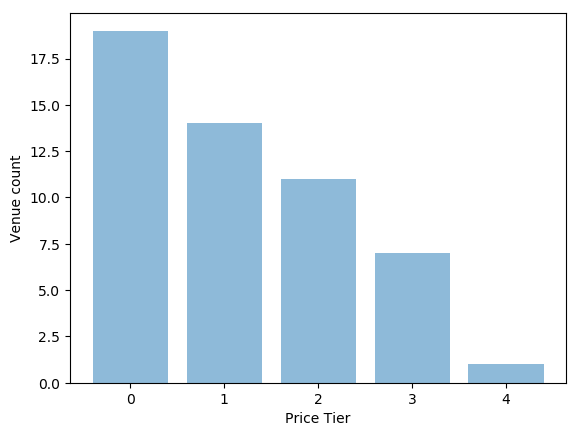

In [190]:
x=cluster_0_price.index
y=cluster_0_price['postalCode']

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Venue count')
plt.xlabel('Price Tier')

From this bar chart, we can say that in cluster 0 most venues are "cheap"

In [182]:
cluster_0_rating=clustering_df[clustering_df['ClusterLabels']==0].groupby('rating').count()

Text(0.5, 0, 'Rating')

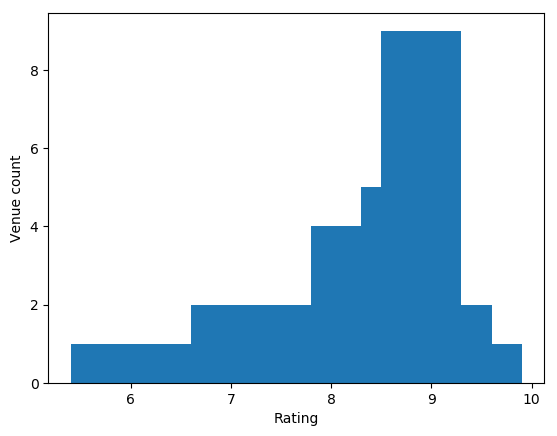

In [192]:
x=cluster_0_rating.index
y=cluster_0_rating['postalCode']

plt.bar(x, y, align='center')
plt.ylabel('Venue count')
plt.xlabel('Rating')

From this bar chart, we can say that most venues in this cluster are scored between 8.5 and 9.5.

In [248]:
cluster_0_zip=clustering_df[clustering_df['ClusterLabels']==0]['postalCode'].unique()
print('These are the zipcodes belonging to the cluster:')
for i in cluster_0_zip:
    print(labels_zip[labels_zip['zip_to_num']==i].index[0])

These are the zipcodes belonging to the cluster:
02110
02111
02115
02215
02116
02130


### Cluster 1

In [164]:
clustering_df[clustering_df['ClusterLabels']==1].head()

,postalCode,name,rating,price,ClusterLabels
71,11,Estragon Tapas,7.6,3,1
72,11,Dunkin',6.5,1,1
73,11,Harrison Urban Garden,0.0,0,1
74,12,Eataly Boston,9.1,0,1
75,12,La Pizza & La Pasta,9.1,2,1


In [185]:
cluster_1_price=clustering_df[clustering_df['ClusterLabels']==1].groupby('price').count()

Text(0.5, 0, 'Price Tier')

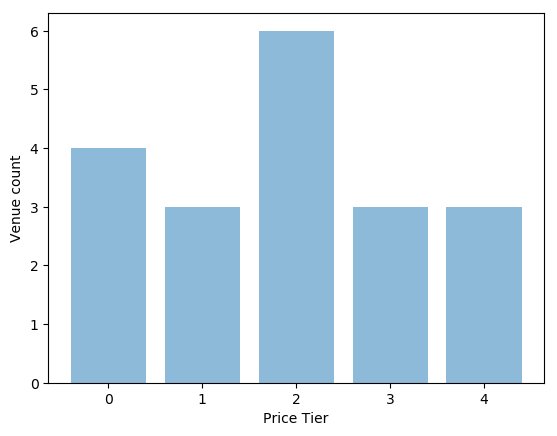

In [193]:
x=cluster_1_price.index
y=cluster_1_price['postalCode']

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Venue count')
plt.xlabel('Price Tier')

Most venues in this cluster have an "average price"

In [186]:
cluster_1_rating=clustering_df[clustering_df['ClusterLabels']==1].groupby('rating').count()

Text(0.5, 0, 'Rating')

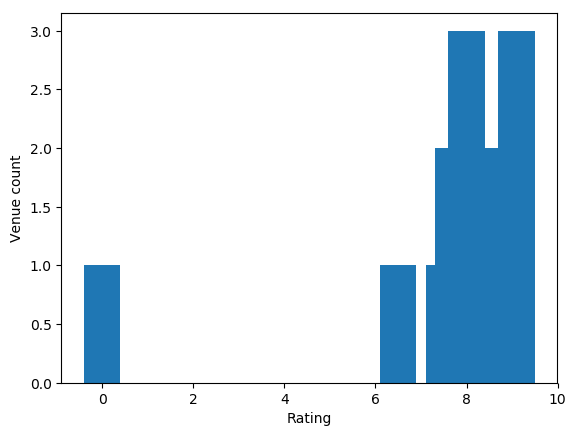

In [194]:
x=cluster_1_rating.index
y=cluster_1_rating['postalCode']

plt.bar(x, y, align='center')
plt.ylabel('Venue count')
plt.xlabel('Rating')

The venues in this cluster clearly have a wide variability when it comes to ratings. However, most of these venues score around 8 and 9.5

In [249]:
cluster_1_zip=clustering_df[clustering_df['ClusterLabels']==1]['postalCode'].unique()
print('These are the zipcodes belonging to the cluster:')
for i in cluster_1_zip:
    print(labels_zip[labels_zip['zip_to_num']==i].index[0])

These are the zipcodes belonging to the cluster:
02118
02199
02210


### Cluster 2

In [167]:
clustering_df[clustering_df['ClusterLabels']==2].head()

,postalCode,name,rating,price,ClusterLabels
28,5,Top Of The Tank,8.4,0,2
34,6,Shabu Zen,9.0,2,2
35,6,La Colombe Torrefaction,8.9,1,2
36,6,Gracenote Coffee,8.8,2,2
37,6,Shojo,8.6,2,2


In [187]:
cluster_2_price=clustering_df[clustering_df['ClusterLabels']==2].groupby('price').count()

Text(0.5, 0, 'Price Tier')

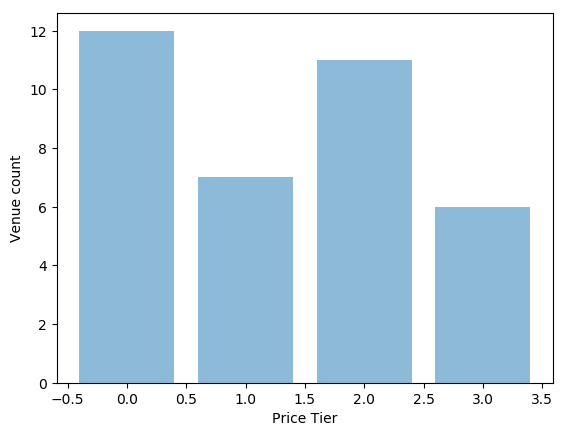

In [195]:
x=cluster_2_price.index
y=cluster_2_price['postalCode']

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Venue count')
plt.xlabel('Price Tier')

The venues in this cluster range from very cheap to average pricing.

In [196]:
cluster_2_rating=clustering_df[clustering_df['ClusterLabels']==2].groupby('rating').count()

Text(0.5, 0, 'Rating')

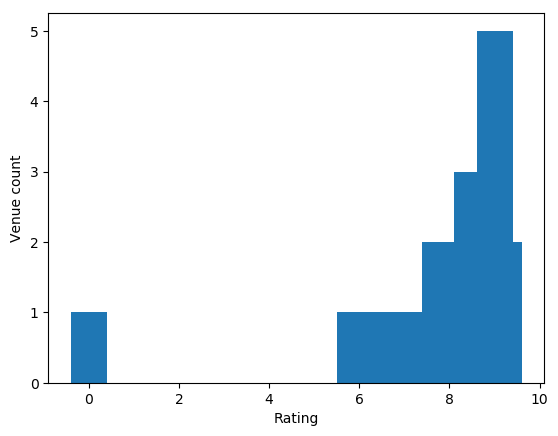

In [197]:
x=cluster_2_rating.index
y=cluster_2_rating['postalCode']

plt.bar(x, y, align='center')
plt.ylabel('Venue count')
plt.xlabel('Rating')

Most venues score at least 9 in this cluster.

In [254]:
cluster_2_zip=clustering_df[clustering_df['ClusterLabels']==2]['postalCode'].unique()
print('These are the zipcodes belonging to the cluster:')
for i in cluster_2_zip:
    try:
        print(labels_zip[labels_zip['zip_to_num']==i].index[0])
    except:
        print("")

These are the zipcodes belonging to the cluster:
02108
02114
02113
02109



## 5. Discussion

Based on this analysis, I'd recommend to the visitors to check out the neighborhoods in the third cluster. The venues contained in this cluster are highly rated and most of them are within very cheap to average price pricing according to reviewers.

It is also interesting to note that in most venues are contained in this venue, which might mean that these nieghborhoods are the most popular ones in Boston. 


## 6. Conclusion

With this project, I used Foursquare API data and US zipcodes dataset to cluster neighborhoods in Boston, MA based on the price and ratings of the venues in the neighborhoods.

After getting the data and preparing it, I split the data into three clusters. Based on this analysis, the neighborhoods with zipcodes 2108, 2114, 2113 and 2109 seem to be the best option for visitors. It also seems to have major number of venues.

Future work could zoom into these neighborhoods to analyze the categories of the venues in these areas. 